In [ ]:
import csv
import os

main_folder_path = '/dhc/home/youngbin.ko/brain_data/data/train_gp_new_120'

input_csv_path = '/dhc/home/youngbin.ko/brain_data/survival_info.csv'
output_csv_path = '/dhc/home/youngbin.ko/brain_data/data/survival_gp.csv'

with open(output_csv_path, 'w', newline='') as csv_output:
    writer = csv.writer(csv_output)
    
    for subfolder_name in sorted(os.listdir(main_folder_path)):
        subfolder_path = os.path.join(main_folder_path, subfolder_name)
        
        if os.path.isdir(subfolder_path):
            with open(input_csv_path, 'r') as csv_input:
                reader = csv.reader(csv_input)
                
                filtered_rows = filter(lambda row: row[0] == subfolder_name, reader)
                sorted_rows = sorted(filtered_rows, key=lambda row: row[0])
                
                writer.writerows(sorted_rows)


In [ ]:
path = np.load("/dhc/home/youngbin.ko/random.npy",allow_pickle=True)

In [ ]:
import shutil

source_folder_path_1 = "/dhc/home/youngbin.ko/brain_data/data/train_for_nf_344"
source_folder_path_2 = "/dhc/home/youngbin.ko/brain_data/train_for_guassian_120"
target_path = "/dhc/home/youngbin.ko/brain_data/data/train_nf"

for folder_name in os.listdir(source_folder_path_1):
    src_path = os.path.join(source_folder_path_1, folder_name)
    dst_path = os.path.join(target_path, folder_name)
    shutil.copytree(src_path, dst_path)

for folder_name in os.listdir(source_folder_path_2):
    src_path = os.path.join(source_folder_path_2, folder_name)
    dst_path = os.path.join(target_path, folder_name)
    shutil.copytree(src_path, dst_path)

In [ ]:
parent_folder_path = "/dhc/home/youngbin.ko/brain_data/data/train_nf"
target_path = "/dhc/home/youngbin.ko/brain_data/data/train_gp_new_120"

folders_to_move = path

for folder_name in os.listdir(parent_folder_path):
    if folder_name in folders_to_move:
        src_path = os.path.join(parent_folder_path, folder_name)
        dst_path = os.path.join(target_path, folder_name)
        shutil.move(src_path, dst_path)


In [ ]:
input_dir = "/dhc/home/youngbin.ko/glow_brain/data_gp/slices_64_new" # Shape (155, 64, 64, 4) npy
input_files = sorted(os.listdir(input_dir))
input_data = np.concatenate([np.expand_dims((np.load(os.path.join(input_dir, f))),0) for f in input_files], axis=0)

In [ ]:
print(input_data.shape)

In [ ]:
reshaped_input = np.reshape(input_data, (120, 155*64*64*4))
print(reshaped_input.shape)

In [ ]:
import numpy as np
import torch
import gpytorch
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

input_dir = "/dhc/home/youngbin.ko/glow_brain/model/output" # Shape (1, 2539520) npy
input_files = sorted(os.listdir(input_dir))
input_data = np.concatenate([np.load(os.path.join(input_dir, f)) for f in input_files], axis=0)
print(input_data.shape) #
train_x = torch.from_numpy(input_data).float().to(device)

output_data = np.load("/dhc/home/youngbin.ko/brain_data/data/survival_days.npy")  # Shape (120,)
train_y = torch.from_numpy(output_data.flatten()).float().view(-1, 1).to(device)
#train_y = torch.from_numpy(output_data).float().view(-1, 1)  # Reshape to (120, 1)
print(train_y.shape)

k=4
input_folds = np.array_split(input_data, k)
output_folds = np.array_split(output_data, k)

class GaussianProcessModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()  # Use a constant mean function
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()  # Use an RBF kernel
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
#gpytorch.likelihoods.BetaLikelihood
model = GaussianProcessModel(train_x, train_y, likelihood)

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

num_epochs = 100
for epoch in range(num_epochs):
    model.train()

    optimizer.zero_grad()

    output = model(train_x)
    loss = -likelihood(output).log_prob(train_y).mean()

    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss {loss.item()}")


In [ ]:
import numpy as np
import torch
import gpytorch
from sklearn.model_selection import KFold
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

input_dir = "/dhc/home/youngbin.ko/glow_brain/model/output" # Shape (1,2539520 ) npy
input_files = sorted(os.listdir(input_dir))
input_data = np.concatenate([np.load(os.path.join(input_dir, f)) for f in input_files], axis=0)
print(input_data.shape) #(120,2539520)
train_x = torch.from_numpy(input_data).float().to(device)

output_data = np.load("/dhc/home/youngbin.ko/brain_data/data/survival_days.npy")  # Shape (120,)
train_y = torch.from_numpy(output_data.flatten()).float().view(-1, 1).to(device)  # Reshape to (120, 1)
print(train_y.shape) #(120, 1)

In [ ]:
class GaussianProcessModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()  # Use a constant mean function
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()  # Use an RBF kernel
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [ ]:
kf = KFold(n_splits=4, shuffle=True, random_state=42)
num_epochs = 100

for fold, (train_index, valid_index) in enumerate(kf.split(train_x)):
    # Get train and validation data
    train_x_fold = train_x[train_index]
    train_y_fold = train_y[train_index]
    valid_x_fold = train_x[valid_index]
    valid_y_fold = train_y[valid_index]

    # Initialize model and likelihood
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GaussianProcessModel(train_x_fold, train_y_fold, likelihood)

    # Define optimizer
    optimizer = torch.optim.LBFGS(model.parameters(), line_search_fn='strong_wolfe')

    # Train the model
    def closure():
        optimizer.zero_grad()
        output = model(train_x_fold)
        loss = -likelihood(output).log_prob(train_y_fold).mean()
        loss.backward()
        return loss

    for epoch in range(num_epochs):
        model.train()
        optimizer.step(closure)
        if epoch % 10 == 0:
            print(f"Fold {fold}, Epoch {epoch}, Loss {closure().item()}")

    # Evaluate the model on the validation set
    model.eval()
    with torch.no_grad():
        output = model(valid_x_fold)
        loss = -likelihood(output).log_prob(valid_y_fold).mean()
        print(f"Fold {fold}, Validation Loss: {loss.item()}")

        f_preds = model(valid_x_fold)
        y_preds = likelihood(model(valid_x_fold))
        f_mean = f_preds.mean
        f_var = f_preds.variance
        f_covar = f_preds.covariance_matrix
        f_samples = f_preds.sample(sample_shape=torch.Size(1000,))

In [ ]:
import numpy as np
import torch
import gpytorch
from sklearn.model_selection import KFold
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

input_dir = "/dhc/home/youngbin.ko/glow_brain/model/output" # Shape (1,2539520 ) npy
input_files = sorted(os.listdir(input_dir))
input_data = np.concatenate([np.load(os.path.join(input_dir, f)) for f in input_files], axis=0)
print(input_data.shape) #(120,2539520)
train_x = torch.from_numpy(input_data).float().to(device)

output_data = np.load("/dhc/home/youngbin.ko/brain_data/data/survival_days.npy")  # Shape (120,)
train_y = torch.from_numpy(output_data).float().view(-1, 1).to(device)  # Reshape to (120, 1)
print(train_y.shape) #(120, 1)

kf = KFold(n_splits=4, shuffle=True, random_state=42)
num_epochs = 100

for fold, (train_index, valid_index) in enumerate(kf.split(train_x)):
    # Get train and validation data
    train_x_fold = train_x[train_index]
    train_y_fold = train_y[train_index]
    valid_x_fold = train_x[valid_index]
    valid_y_fold = train_y[valid_index]

    # Initialize model and likelihood
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GaussianProcessModel(train_x_fold, train_y_fold, likelihood)

    # Define optimizer
    optimizer = torch.optim.LBFGS(model.parameters(), line_search_fn='strong_wolfe')

    # Train the model
    def closure():
        optimizer.zero_grad()
        output = model(train_x_fold)
        loss = -likelihood(output).log_prob(train_y_fold).mean()
        loss.backward()
        return loss

    for epoch in range(num_epochs):
        model.train()
        optimizer.step(closure)
        if epoch % 10 == 0:
            print(f"Fold {fold}, Epoch {epoch}, Loss {closure().item()}")

    # Evaluate the model on the validation set
    model.eval()
    with torch.no_grad():
        output = model(valid_x_fold)
        loss = -likelihood(output).log_prob(valid_y_fold).mean()
        print(f"Fold {fold}, Validation Loss: {loss.item()}")

        f_preds = model(valid_x_fold)
        y_preds = likelihood(model(valid_x_fold))
        f_mean = f_preds.mean
        f_var = f_preds.variance
        f_covar = f_preds.covariance_matrix
        f_samples = f_preds.sample(sample_shape=torch.Size(1000,))

In [ ]:
class GaussianProcessModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()  # Use a constant mean function
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()  # Use an RBF kernel
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        #mean_x = mean_x.view(-1, 1)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [ ]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [1]:
import numpy as np
import torch
import gpytorch
from sklearn.model_selection import KFold
import os

# check if GPU is available and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
#device = torch.device('cpu')
input_dir = "/dhc/home/youngbin.ko/glow_brain/model/output" # Shape (1,2539520 ) npy
input_files = sorted(os.listdir(input_dir))
input_data = np.concatenate([np.load(os.path.join(input_dir, f)) for f in input_files], axis=0)
print(input_data.shape) #(120,2539520)
train_x = torch.from_numpy(input_data).float().to(device)
#train_x = torch.from_numpy(input_data).float()

output_data = np.load("/dhc/home/youngbin.ko/brain_data/data/survival_days.npy")  # Shape (120,)
train_y = torch.from_numpy(output_data.flatten()).float().to(device)
#train_y = torch.from_numpy(output_data.flatten()).float().view(1, -1).to(device)  # Reshape to (120, 1)
#train_y = torch.from_numpy(output_data.flatten()).float().view(-1, 1) 
print(train_y.shape) #(120, 1)

kf = KFold(n_splits=4, shuffle=True, random_state=42)
num_epochs = 100

class GaussianProcessModel(gpytorch.models.ExactGP): #change to linear regression (output from NF) 
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()  # Use a constant mean function
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()  # Use an RBF kernel
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

for fold, (train_index, valid_index) in enumerate(kf.split(train_x)):
    # Get train and validation data
    train_x_fold = train_x[train_index]
    train_y_fold = train_y[train_index]
    valid_x_fold = train_x[valid_index]
    valid_y_fold = train_y[valid_index]

    # Initialize model and likelihood
    likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
    model = GaussianProcessModel(train_x_fold, train_y_fold, likelihood).to(device)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    # Define optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

    print(f"Fold {fold}, Prior mean: {model.mean_module.constant.item()}")
    print(f"Fold {fold}, Training labels shape: {train_y_fold.shape}")
    # Train the model
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        output = model(train_x_fold)
        #loss = -likelihood(output).log_prob(train_y_fold).mean()
        #loss = ((train_y_fold-output)**2)
        loss = -mll(output, train_y_fold)
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f"Fold {fold}, Epoch {epoch}, Loss {loss.item()}")

    # Evaluate the model on the validation set
    model.eval()
    with torch.no_grad():
        output = model(valid_x_fold)
        loss = -likelihood(output).log_prob(valid_y_fold).mean()
        print(f"Fold {fold}, Validation Loss: {loss.item()}")

        f_preds = model(valid_x_fold)
        y_preds = likelihood(model(valid_x_fold))
        f_mean = f_preds.mean
        f_var = f_preds.variance
        f_covar = f_preds.covariance_matrix
        #f_samples = f_preds.sample(sample_shape=torch.Size(1000,))


/dhc/home/youngbin.ko/conda3/envs/copy_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
(120, 2539520)
torch.Size([120])
Fold 0, Prior mean: 0.0
Fold 0, Training labels shape: torch.Size([90])
Fold 0, Epoch 0, Loss 144536.71875
Fold 0, Epoch 10, Loss 77837.0859375
Fold 0, Epoch 20, Loss 52163.8359375
Fold 0, Epoch 30, Loss 40709.44140625
Fold 0, Epoch 40, Loss 34614.015625
Fold 0, Epoch 50, Loss 30844.60546875
Fold 0, Epoch 60, Loss 28225.6640625
Fold 0, Epoch 70, Loss 26246.900390625
Fold 0, Epoch 80, Loss 24664.056640625
Fold 0, Epoch 90, Loss 23348.8203125
Fold 0, Validation Loss: 556400.1875
Fold 1, Prior mean: 0.0
Fold 1, Training labels shape: torch.Size([90])
Fold 1, Epoch 0, Loss 121153.8671875
Fold 1, Epoch 10, Loss 65233.2578125
Fold 1, Epoch 20, Loss 43710.99609375
Fold 1, Epoch 30, Loss 34108.875
Fold 1, Epoch 40, Loss 28999.029296875
Fold 1, Epoch 50, Loss 25838.91796875
Fold 1, Epoch 60, Loss 23643.162109375
Fold 1, Epoch 70, Loss 21984.01953125
Fold 1, Epoch 80, Loss 20656.763671875
Fold 1, Epoch 90, Loss 19553.8359375
Fold 1, Validation 

In [14]:
y_preds.mean.cpu()

tensor([6.3258, 6.3258, 6.3258, 6.3258, 6.3258, 6.3258, 6.3258, 6.3258, 6.3258,
        6.3258, 6.3258, 6.3258, 6.3258, 6.3258, 6.3258, 6.3258, 6.3258, 6.3258,
        6.3258, 6.3258, 6.3258, 6.3258, 6.3258, 6.3258, 6.3258, 6.3258, 6.3258,
        6.3258, 6.3258, 6.3258])

In [ ]:
ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')

In [11]:
type(y_preds)

gpytorch.distributions.multivariate_normal.MultivariateNormal

In [12]:
print(f_mean)

tensor([6.3258, 6.3258, 6.3258, 6.3258, 6.3258, 6.3258, 6.3258, 6.3258, 6.3258,
        6.3258, 6.3258, 6.3258, 6.3258, 6.3258, 6.3258, 6.3258, 6.3258, 6.3258,
        6.3258, 6.3258, 6.3258, 6.3258, 6.3258, 6.3258, 6.3258, 6.3258, 6.3258,
        6.3258, 6.3258, 6.3258], device='cuda:0')


In [10]:
print(f)

tensor([ 788.,  465.,  336., 1283.,   33.,  229., 1592.,  614.,   58.,  416.,
         240.,  300.,  630.,  630.,  355.,  737.,   67.,  828.,  747.,  103.,
         382.,  372.,  232.,  434.,  244.,   82.,  147.,  260.,  184.,   62.],
       device='cuda:0')


In [24]:
#linear regression with output from NF
import numpy as np
import torch
import os
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

input_dir = "/dhc/home/youngbin.ko/glow_brain/model/output" # Shape (1,2539520 ) npy
input_files = sorted(os.listdir(input_dir))
input_data = np.concatenate([np.load(os.path.join(input_dir, f)) for f in input_files], axis=0)
print(input_data.shape) #(120,2539520)

output_data = np.load("/dhc/home/youngbin.ko/brain_data/data/survival_days.npy")  # Shape (120,)
input_data = torch.from_numpy(input_data).float().to(device)
output_data = torch.from_numpy(output_data.flatten()).float().to(device)

train_X, test_X, train_y, test_y = train_test_split(input_data, output_data, test_size=0.2, random_state=10)
train_X, valid_X, train_y, valid_y = train_test_split(train_X, train_y, test_size=0.25, random_state=10)

class BrainDataset(Dataset):
    def __init__(self, input_data, output_data):
        self.input_data = input_data
        self.output_data = output_data
    
    def __len__(self):
        return len(self.input_data)
    
    def __getitem__(self, index):
        x = self.input_data[index]
        y = self.output_data[index]
        return x, y

dataset = BrainDataset(input_data, output_data)

train_loader = DataLoader(TensorDataset(train_X, train_y), batch_size=10, shuffle=True) # shape (72, 155, 64, 64, 4)
valid_loader = DataLoader(TensorDataset(valid_X, valid_y), batch_size=10)
test_loader = DataLoader(TensorDataset(test_X, test_y), batch_size=10)

num_epochs = 100

class LinearRegressionModel(torch.nn.Module):
    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        self.linear = torch.nn.Linear(input_data.shape[1], 1)

    def forward(self, x):
        out = self.linear(x)
        return out

model = LinearRegressionModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

def mse_loss(preds, targets):
    return torch.mean((preds - targets)**2)

print(f"Training labels shape: {train_y.shape}")
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = mse_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print(f"Epoch {epoch}, Batch {batch_idx}, Loss {loss.item()}")
    
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for data, target in valid_loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            val_loss += mse_loss(output.flatten(), target).item() * data.size(0)
        val_loss /= len(valid_loader.dataset)
        print(f"Validation Loss: {val_loss}")

model.eval()
with torch.no_grad():
    test_loss = 0
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        test_loss += mse_loss(output.flatten(), target).item() * data.size(0)
    test_loss /= len(test_loader.dataset)
    print(f"Test Loss: {test_loss}")

Using device: cuda
(120, 2539520)
Training labels shape: torch.Size([72])
Epoch 0, Batch 0, Loss 554946.0625
Validation Loss: 54195292.0
Epoch 1, Batch 0, Loss 590920512.0
Validation Loss: 62038020.666666664
Epoch 2, Batch 0, Loss 393443552.0
Validation Loss: 49332696.666666664
Epoch 3, Batch 0, Loss 90849408.0
Validation Loss: 59123485.0
Epoch 4, Batch 0, Loss 186308864.0
Validation Loss: 53932918.0
Epoch 5, Batch 0, Loss 153213168.0
Validation Loss: 57937386.333333336
Epoch 6, Batch 0, Loss 149286384.0
Validation Loss: 31123444.5
Epoch 7, Batch 0, Loss 168872880.0
Validation Loss: 26625763.666666668
Epoch 8, Batch 0, Loss 66833356.0
Validation Loss: 3795137.8125
Epoch 9, Batch 0, Loss 10387434.0
Validation Loss: 213051.58951822916
Epoch 10, Batch 0, Loss 59301652.0
Validation Loss: 25611759.333333332
Epoch 11, Batch 0, Loss 19512442.0
Validation Loss: 50561393.666666664
Epoch 12, Batch 0, Loss 70840848.0
Validation Loss: 113487710.66666667
Epoch 13, Batch 0, Loss 124057000.0
Validati

In [26]:
import math 
math.sqrt(178346153.33333334)

13354.630407964623

In [15]:
# cnn with original data
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_dir = "/dhc/home/youngbin.ko/glow_brain/data_gp/slices_64_new"
input_files = sorted(os.listdir(input_dir))
X = []
for f in input_files:
    data = np.load(os.path.join(input_dir, f))  # Shape (155, 64, 64, 4)
    X.append(data)
X = np.stack(X, axis=0)  # Shape (120, 155, 64, 64, 4)
X = np.transpose(X, (0, 4, 2, 3, 1))
output_data = np.load("/dhc/home/youngbin.ko/brain_data/data/survival_days.npy")  # Shape (120,)

train_X, test_X, train_y, test_y = train_test_split(X, output_data, test_size=0.2, random_state=10)
train_X, valid_X, train_y, valid_y = train_test_split(train_X, train_y, test_size=0.25, random_state=10)

train_loader = DataLoader(TensorDataset(torch.from_numpy(train_X).float().to(device), torch.from_numpy(train_y).float().to(device)), batch_size=10, shuffle=True) # shape (72, 155, 64, 64, 4)
valid_loader = DataLoader(TensorDataset(torch.from_numpy(valid_X).float().to(device), torch.from_numpy(valid_y).float().to(device)), batch_size=10)
test_loader = DataLoader(TensorDataset(torch.from_numpy(test_X).float().to(device), torch.from_numpy(test_y).float().to(device)), batch_size=10)

class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        self.conv1 = nn.Conv3d(4, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv3d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 16 * 16 * 19, 10)
        self.fc2 = nn.Linear(10, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 16 * 16 * 19)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def train(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for i, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    return epoch_loss

def evaluate(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item()
    epoch_loss = running_loss / len(val_loader)
    return epoch_loss

model = MyCNN().to(device)

#criterion = nn.MSELoss()
def mse_loss(preds, targets):
    return torch.mean((preds - targets)**2)

optimizer = optim.Adam(model.parameters())

num_epochs = 100
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, mse_loss, optimizer)
    val_loss = evaluate(model, valid_loader, mse_loss)
    print('Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}'.format(epoch+1, num_epochs, train_loss, val_loss))

test_loss = evaluate(model, test_loader, mse_loss)
print('Test Loss: {:.4f}'.format(test_loss))

Epoch [1/100], Train Loss: 236800.9062, Val Loss: 140198.2682
Epoch [2/100], Train Loss: 138817.2422, Val Loss: 164167.1217
Epoch [3/100], Train Loss: 115249.2087, Val Loss: 139529.9017
Epoch [4/100], Train Loss: 114156.2715, Val Loss: 162080.0202
Epoch [5/100], Train Loss: 120935.0771, Val Loss: 143291.2266
Epoch [6/100], Train Loss: 111241.9325, Val Loss: 150475.8145
Epoch [7/100], Train Loss: 117123.2451, Val Loss: 143783.2845
Epoch [8/100], Train Loss: 124452.5962, Val Loss: 145489.3887
Epoch [9/100], Train Loss: 120290.6357, Val Loss: 153915.1549
Epoch [10/100], Train Loss: 156452.8516, Val Loss: 139449.2077
Epoch [11/100], Train Loss: 134681.5356, Val Loss: 148795.8275
Epoch [12/100], Train Loss: 122880.5576, Val Loss: 139511.2210
Epoch [13/100], Train Loss: 112056.1023, Val Loss: 151516.5477
Epoch [14/100], Train Loss: 116363.6484, Val Loss: 148350.7012
Epoch [15/100], Train Loss: 112022.3271, Val Loss: 148635.8504
Epoch [16/100], Train Loss: 112136.6595, Val Loss: 140904.3190
E

In [27]:
math.sqrt(152835.9313)

390.94236314321324

In [1]:
import numpy as np
import torch
import gpytorch
from sklearn.model_selection import train_test_split
import os

/dhc/home/youngbin.ko/conda3/envs/copy_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
input_dir = "/dhc/home/youngbin.ko/glow_brain/data_gp/slices_64_new"
input_files = sorted(os.listdir(input_dir))
result = []

for f in input_files:
  data = np.load(os.path.join(input_dir, f))
  result.append(data.reshape(1, -1))

result = np.concatenate(result, axis=0)
print(result.shape)

(120, 2539520)


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [4]:
#GP using MSE, original data
input_data = result

output_data = np.load("/dhc/home/youngbin.ko/brain_data/data/survival_days.npy")  # Shape (120,)
train_x, test_x, train_y, test_y = train_test_split(input_data, output_data, test_size=0.2, random_state=10)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.25, random_state=10)

train_x = torch.from_numpy(train_x).float().to(device)
train_y = torch.from_numpy(train_y).float().to(device)
valid_x = torch.from_numpy(valid_x).float().to(device)
valid_y = torch.from_numpy(valid_y).float().to(device)
test_x = torch.from_numpy(test_x).float().to(device)
test_y = torch.from_numpy(test_y).float().to(device)

# Define Gaussian Process Regression model
class GaussianProcessRegression(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y):
        super().__init__(train_x, train_y, gpytorch.likelihoods.GaussianLikelihood())
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialize model
model = GaussianProcessRegression(train_x, train_y).to(device)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
loss_fn = torch.nn.MSELoss()

# Train the model
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    output = model(train_x)
    loss = loss_fn(output.mean, train_y)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss {loss.item()}")

# Evaluate the model on the validation set
model.eval()
with torch.no_grad():
    output = model(valid_x)
    loss = loss_fn(output.mean, valid_y)
    print(f"Validation Loss: {loss.item()}")

    y_preds = output.mean
    y_var = output.variance


Epoch 0, Loss 303609.6875
Epoch 10, Loss 302756.53125
Epoch 20, Loss 301905.75
Epoch 30, Loss 301057.5
Epoch 40, Loss 300212.125
Epoch 50, Loss 299369.5625
Epoch 60, Loss 298529.90625
Epoch 70, Loss 297693.1875
Epoch 80, Loss 296859.4375
Epoch 90, Loss 296028.625
Epoch 100, Loss 295200.75
Epoch 110, Loss 294375.75
Epoch 120, Loss 293553.6875
Epoch 130, Loss 292734.5625
Epoch 140, Loss 291918.28125
Epoch 150, Loss 291104.90625
Epoch 160, Loss 290294.40625
Epoch 170, Loss 289486.75
Epoch 180, Loss 288681.9375
Epoch 190, Loss 287880.0625
Validation Loss: 410864.9375


In [14]:
#early stopping
#original data
#input_data = result

#Glow output
input_dir = "/dhc/home/youngbin.ko/glow_brain/model/output" # Shape (1,2539520 ) npy
input_files = sorted(os.listdir(input_dir))
input_data = np.concatenate([np.load(os.path.join(input_dir, f)) for f in input_files], axis=0)
output_data = np.load("/dhc/home/youngbin.ko/brain_data/data/survival_days.npy")  # Shape (120,)
train_x, test_x, train_y, test_y = train_test_split(input_data, output_data, test_size=0.2, random_state=10)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.25, random_state=10)

train_x = torch.from_numpy(train_x).float().to(device)
train_y = torch.from_numpy(train_y).float().to(device)
valid_x = torch.from_numpy(valid_x).float().to(device)
valid_y = torch.from_numpy(valid_y).float().to(device)
test_x = torch.from_numpy(test_x).float().to(device)
test_y = torch.from_numpy(test_y).float().to(device)

# Define Gaussian Process Regression model
class GaussianProcessRegression(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialize model and likelihood
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
model = GaussianProcessRegression(train_x, train_y, likelihood).to(device)

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# Train the model with early stopping
model.train()
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
best_loss = float("inf")
patience = 10  # Stop training if validation loss does not improve for 10 epochs
counter = 0
for epoch in range(100):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss {loss.item()}")

    # Evaluate the model on the validation set and check for improvement
    model.eval()
    with torch.no_grad():
        output = model(valid_x)
        mse_valid = torch.nn.functional.mse_loss(output.mean, valid_y)
        loss = -mll(output, valid_y)
        print(f"Validation Loss: {loss.item()}, Validation MSE {mse_valid}")
        if loss < best_loss:
            best_loss = loss
            counter = 0
        else:
            counter += 1
        if counter >= patience:
            print(f"No improvement in {patience} epochs, stopping early.")
            break
    model.train()

# Evaluate the final model on the test set
model.eval()
with torch.no_grad():
    output = model(test_x)
    mse_test = torch.nn.functional.mse_loss(output.mean, test_y)
    loss = -mll(output, test_y)
    print(f"Test Loss: {loss.item()}, Test MSE: {mse_test}")

    f_preds = model(test_x)
    y_preds = likelihood(f_preds)
    f_mean = f_preds.mean
    f_var = f_preds.variance
    f_covar = f_preds.covariance_matrix


Epoch 0, Loss 109497.2421875
Validation Loss: 185085.234375, Validation MSE 430641.3125
Validation Loss: 172625.625, Validation MSE 430539.25
Validation Loss: 161330.984375, Validation MSE 430437.6875
Validation Loss: 151100.03125, Validation MSE 430336.5625
Validation Loss: 141836.46875, Validation MSE 430236.25
Validation Loss: 133449.78125, Validation MSE 430136.75
Validation Loss: 125855.53125, Validation MSE 430038.25
Validation Loss: 118975.7421875, Validation MSE 429940.75
Validation Loss: 112738.875, Validation MSE 429844.3125
Validation Loss: 107079.609375, Validation MSE 429749.09375
Epoch 10, Loss 58947.0546875
Validation Loss: 101938.84375, Validation MSE 429655.1875
Validation Loss: 97263.09375, Validation MSE 429562.4375
Validation Loss: 93004.328125, Validation MSE 429471.09375
Validation Loss: 89119.46875, Validation MSE 429381.09375
Validation Loss: 85569.921875, Validation MSE 429292.4375
Validation Loss: 82321.28125, Validation MSE 429205.09375
Validation Loss: 79342

In [16]:
import math
math.sqrt(481830.5)

694.1401155386425

In [3]:
# GP using GLOW output, MSE
input_dir = "/dhc/home/youngbin.ko/glow_brain/model/output" # Shape (1,2539520 ) npy
input_files = sorted(os.listdir(input_dir))
input_data = np.concatenate([np.load(os.path.join(input_dir, f)) for f in input_files], axis=0)
print(input_data.shape)
# input_dir = "/dhc/home/youngbin.ko/glow_brain/data_gp/slices_64_new"
# input_files = sorted(os.listdir(input_dir))
# result = []

# for f in input_files:
#   data = np.load(os.path.join(input_dir, f))
#   result.append(data.reshape(1, -1))

# input_data = np.concatenate(result, axis=0)

output_data = np.load("/dhc/home/youngbin.ko/brain_data/data/survival_days.npy")  # Shape (120,)
train_x, test_x, train_y, test_y = train_test_split(input_data, output_data, test_size=0.2, random_state=10)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.25, random_state=10)

train_x = torch.from_numpy(train_x).float().to(device)
train_y = torch.from_numpy(train_y).float().to(device)
valid_x = torch.from_numpy(valid_x).float().to(device)
valid_y = torch.from_numpy(valid_y).float().to(device)
test_x = torch.from_numpy(test_x).float().to(device)
test_y = torch.from_numpy(test_y).float().to(device)

class GaussianProcessRegression(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y):
        super().__init__(train_x, train_y, gpytorch.likelihoods.GaussianLikelihood())
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x, x_valid=None):
        if x_valid is None:
            mean_x = self.mean_module(x)
            covar_x = self.covar_module(x)
        else:
            mean_x = self.mean_module(x_valid)
            covar_x = self.covar_module(x_valid)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialize model
model = GaussianProcessRegression(train_x, train_y).to(device)
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
#loss_fn = torch.nn.MSELoss()

# Define hyperparameters
n_iterations = 10
patience = 5
best_loss = float('inf')
counter = 0

# Train the model
model.train()
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
for epoch in range(100):
    optimizer.zero_grad()
    output = model(train_x)
    # loss = loss_fn(output.mean, train_y)
    # train_loss = loss.item()
    train_loss = -mll(output, train_y)
    train_loss.backward()
    optimizer.step()
    
    if epoch % n_iterations == 0:
        model.eval()
        with torch.no_grad():
            output = model(valid_x, valid_x)
            mse_valid = torch.nn.functional.mse_loss(output.mean, valid_y)
            loss = -mll(output, valid_y)
            valid_loss = loss.item()
            
            if valid_loss < best_loss:
                best_loss = valid_loss
                counter = 0
            else:
                counter += 1
                
            if counter >= patience:
                print(f"No improvement in {patience} epochs, stopping early.")
                break
                
        model.train()
        print(f"Epoch {epoch}, Training Loss {train_loss}, Validation Loss {valid_loss}, Validation MSE {mse_valid}")
# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    output = model(test_x, test_x)
    mse_test = torch.nn.functional.mse_loss(output.mean, test_y)
    loss = -mll(output, test_y)
    print(f"Test Loss: {loss.item()}, Test MSE: {mse_test}")
    y_preds = output.mean
    y_var = output.variance


(120, 2539520)
Epoch 0, Training Loss 109497.2421875, Validation Loss 193661.5625, Validation MSE 430641.3125
Epoch 10, Training Loss 75780.28125, Validation Loss 146922.625, Validation MSE 429637.84375
Epoch 20, Training Loss 55354.41015625, Validation Loss 114798.9375, Validation MSE 428712.25
Epoch 30, Training Loss 44045.98828125, Validation Loss 95311.28125, Validation MSE 427888.4375
Epoch 40, Training Loss 37472.64453125, Validation Loss 83253.71875, Validation MSE 427154.6875
Epoch 50, Training Loss 33284.71484375, Validation Loss 75232.296875, Validation MSE 426487.21875
Epoch 60, Training Loss 30366.12109375, Validation Loss 69465.8515625, Validation MSE 425864.8125
Epoch 70, Training Loss 28177.5390625, Validation Loss 65041.12109375, Validation MSE 425272.3125
Epoch 80, Training Loss 26444.099609375, Validation Loss 61474.54296875, Validation MSE 424700.0
Epoch 90, Training Loss 25016.2734375, Validation Loss 58495.9765625, Validation MSE 424142.09375
Test Loss: 61457.68359

In [12]:
import math
math.sqrt(424142.09375)

651.261924075099

In [4]:
from matplotlib import pyplot as plt

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

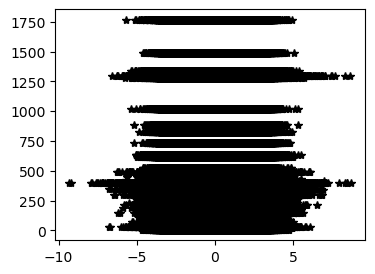

In [6]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = y_preds.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.cpu(), train_y.cpu(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.cpu(), y_preds.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.cpu(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])